In [48]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.widgets import *
from PIL import Image

In [49]:
from fastbook import *
urls = search_images_ddg('guitarra', max_images=100)
len(urls),urls[0]

(100,
 'http://www.musicallweb.com/wp-content/uploads/2019/05/Guitarra-Acustica-Clasica-Orich-RojaNegro_1.jpg')

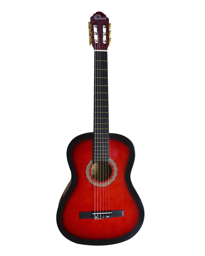

In [50]:
download_url(urls[0], 'images/guitarra.jpg')
im = Image.open('images/guitarra.jpg')
im.thumbnail((256,256))
im

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Descargamos las imagenes que usaremos para el modelo

In [51]:
instrumentos = 'guitarra','ukelele','bajo'
path = Path('gdrive/MyDrive/instrumentos')

if not path.exists():
  path.mkdir()
  for o in instrumentos:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} instrumento', max_images=10)
    cont = 0
    for i in results:
      try:
        download_url(i, str(dest) + "/" + str(cont) + ".jpg")
      except:
        print('Error')  
      cont += 1

Error


Error


Error


Error


Error


In [36]:
fns = get_image_files(path)
fns

(#295) [Path('gdrive/MyDrive/instrumentos/guitarra/0.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/1.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/2.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/3.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/4.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/5.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/6.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/8.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/9.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/10.jpg')...]

Limpiamos las imagenes descargadas que estén corruptas

In [37]:
failed = verify_images(fns)
failed.map(Path.unlink);

Creamos el DataLoader

In [38]:
instrumentos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Entrenamos el modelo con las imágenes

In [39]:
instrumentos = instrumentos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = instrumentos.dataloaders(path)

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

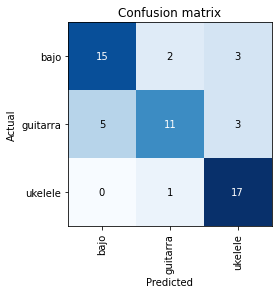

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

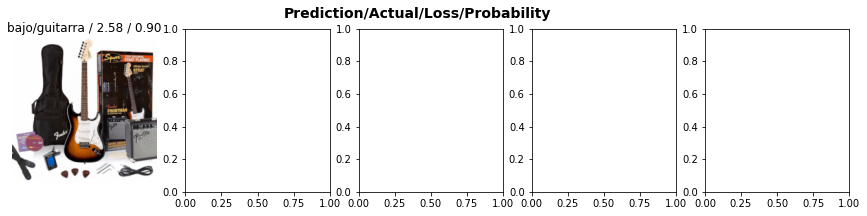

In [42]:
interp.plot_top_losses(5, nrows=1)

In [43]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [44]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [45]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Convertimos el modelo en una aplicación online

In [46]:
learn.export()

In [47]:
import PIL
path = Path()
learn_inf = load_learner(path/'export.pkl',cpu=True)
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

btn_run = widgets.Button(description='Clasificar')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Predicción: {pred}; Probabilidad: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

VBox([widgets.Label('Seleciona tu instrumento'), 
      btn_upload, btn_run, out_pl, lbl_pred])